In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Load Profiles

Notes:

l1_p , l2_p , l3_p : mean power in W. To obtain total energy in Wh consumed during the interval (depends on the granularity):

 - Energy = (l1_p + l2_p + l3_p) / granularity 

Depending on the usage and displayed data, the power of the 3 phases ( l1_p , l2_p , l3_p ) need to be added to form a single value.

In [2]:
day1 = '5fe3412c923d596335e69d4c-20210808-v0.0.1_SE05000139_Kaeltemaschine.csv' ## Sunday
day2 = '5fe3412c923d596335e69d4c-20210809-v0.0.1_SE05000139_Kaeltemaschine.csv' ## Monday
day3 = '5fe3412c923d596335e69d4c-20210810-v0.0.1_SE05000139_Kaeltemaschine.csv' ## Tuesday
day1 = pd.read_csv('/Users/wastechs/Documents/data/Kaeltemaschine/{}'.format(day1))
day2 = pd.read_csv('/Users/wastechs/Documents/data/Kaeltemaschine/{}'.format(day2))
day3 = pd.read_csv('/Users/wastechs/Documents/data/Kaeltemaschine/{}'.format(day3))

In [3]:
def epoch_convert(df):
    df.t = pd.to_datetime(df.t, unit='s')
    df.set_index(df.t, inplace=True)
    del df['t']
    return df

In [4]:
day1 = epoch_convert(day1)
day2 = epoch_convert(day2)
day3 = epoch_convert(day3)

In [5]:
machine = pd.concat([day1, day2, day3])

In [20]:
machine

,L,V,I,S,P,Q,PF,PHI
t,,,,,,,,
2021-08-07 21:59:00.200999975,1.0,238.921,31.026,7411.529,4752.550,5675.528,0.642,120.00
2021-08-07 21:59:00.200999975,2.0,239.071,29.281,6998.035,4515.562,5331.538,0.647,120.00
2021-08-07 21:59:00.200999975,3.0,240.536,30.406,7315.965,4822.356,5482.820,0.659,120.00
2021-08-07 21:59:00.282999992,1.0,238.920,30.994,7403.923,4749.859,5656.511,0.642,120.00
2021-08-07 21:59:00.282999992,2.0,239.067,29.265,6994.562,4522.702,5318.453,0.647,120.00
...,...,...,...,...,...,...,...,...
2021-08-10 21:58:59.917999983,2.0,238.098,5.017,1194.127,1043.380,570.008,0.874,151.58
2021-08-10 21:58:59.917999983,3.0,239.269,5.396,1291.573,1117.044,635.928,0.865,120.00
2021-08-10 21:59:00.000000000,1.0,237.744,6.195,1472.678,1281.357,716.402,0.871,120.00


In [ ]:
day1.index[3] - day1.index[0]

In [ ]:
def kwatt_avg(df):
    """
    Unbalanced loads (amps vary between phases)
    """
    df_avg = pd.DataFrame(df[['P', 'I', 'V', 'PF']].groupby(df.index).mean())
    df_avg['kW_avg'] = (df_avg['V'] * df_avg['I'] * df_avg['PF'] * np.sqrt(3)) / 1000

    return df_avg

In [ ]:
machine_avg_kw = kwatt_avg(machine)

In [ ]:
def kwatt(df):
    """
    Unbalanced loads (amps vary between phases)
    """

    df['p_total'] = (df['V'] * df['I'] * df['PF']) / 1000

    #df['kW'] = df['p_total'].groupby(df.index).sum()

    #df.index = df.index.drop_duplicates()

    return df

In [ ]:
machine_kw = kwatt(machine)

In [ ]:
machine_kw

In [ ]:
machine_kw.drop_duplicates(subset=['kW'], keep='first', inplace=True)

In [ ]:
machine_kw

In [ ]:
day1_kw = kwatt(day1)
day2_kw = kwatt(day2)
day3_kw = kwatt(day3)

In [ ]:
def decompose_phases(df):
    df_1 = df[df.L == 1.0]
    df_2 = df[df.L == 2.0]
    df_3 = df[df.L == 3.0]

    return df_1, df_2, df_3

In [ ]:
day1_phase1, day1_phase2, day1_phase3 = decompose_phases(day1)
day2_phase1, day2_phase2, day2_phase3 = decompose_phases(day2)
day3_phase1, day3_phase2, day3_phase3 = decompose_phases(day3)

In [36]:
def load_plotter(df, feat, resample=None):
    
    if resample != None:
        plt.figure(figsize=(16, 6))
        plt.plot(df.resample(resample).sum().index, df[feat].resample(resample).mean() / 1000)
        plt.title('Kaeltemaschine')
        plt.xlabel('Time = M-d-H')
        plt.ylabel('Power')
        plt.show()

    else:
        plt.figure(figsize=(16, 6))
        plt.plot(df.index, df[feat])
        plt.title('Kaeltemaschine')
        plt.xlabel('Time = M-d-H')
        plt.ylabel('{}'.format(feat))
        plt.show()

In [51]:
feats = ['V', 'I', 'S', 'P', 'Q', 'PF', 'PHI']

new_df = pd.DataFrame(
    data=machine[feats].resample('5T').mean(),
    index=machine.resample('5T').sum().index)

new_df['kw'] = new_df['P'] / 1000

new_df

,V,I,S,P,Q,PF,PHI,kw
t,,,,,,,,
2021-08-07 21:55:00,239.599281,30.191753,7233.461711,4692.293859,5488.714703,0.648763,137.899583,4.692294
2021-08-07 22:00:00,238.932836,25.268698,6037.169112,3983.620349,4499.394974,0.691215,136.814073,3.983620
2021-08-07 22:05:00,239.020670,5.535246,1322.853949,1145.480842,650.008628,0.866046,134.677281,1.145481
2021-08-07 22:10:00,238.757096,23.162330,5528.241862,3655.219144,4096.875443,0.706851,136.310999,3.655219
2021-08-07 22:15:00,238.808210,30.104900,7188.790033,4677.619675,5442.094673,0.650652,137.473466,4.677620
...,...,...,...,...,...,...,...,...
2021-08-10 21:35:00,237.325930,31.037908,7365.507698,4931.732438,5454.721738,0.669527,137.775045,4.931732
2021-08-10 21:40:00,237.652914,26.900796,6390.955511,4305.084897,4690.791058,0.697939,136.733867,4.305085
2021-08-10 21:45:00,238.075880,17.494907,4164.266865,2916.383064,2904.660516,0.774028,137.024086,2.916383


### Original Resolution

Tuesday:
- Idle / standby mode seems to be occuring from 21:00 until about 7:00
- Normal operations from 7:00 until 19:00 and standby mode again until 7:00
- Three peaks occuring around mid-day and in the afteroon are worth investigating
    - It would be interesting to know what Gassmann was doing in/with the fridge during these time periods?
    - Moving products inside, taking products out. . .

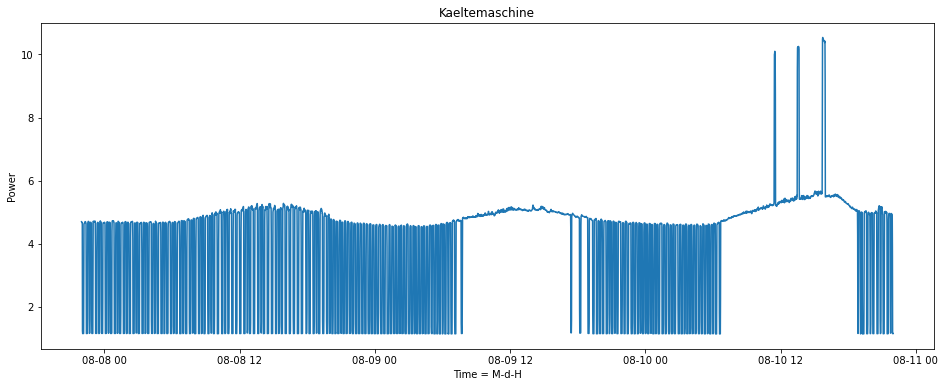

In [54]:
load_plotter(machine, 'P', '1T')

In [ ]:
load_plotter(machine_kw, 'kW')

In [ ]:
load_plotter(machine_avg_kw, 'kW_avg')

In [ ]:
load_plotter(day3_phase1, 'P')

Monday:
- Idle / standby mode seems to be occuring from 21:00 until about 8:00
- Normal operations from 8:00 until 19:00 and standby mode again until 7:00
- The difference with this load profile is there are no peaks occuring. Rather a steady state "normal" operation mode throughout the business hours with a slight linear trend until noon and then a slight linear decreasing trend until ~17:00

In [ ]:
load_plotter(day2_phase1, 'P')

Sunday:
 - Idle / standby mode seems to be occuring for the majority of the day with cycling periods
 - Power consumption increases slightly throughout the day until about ~13:00 and then decreases
    - Possibly due to increasing ambient temperatures?

In [ ]:
load_plotter(day1_phase1, 'P')

Investigating Monday idle mode:
 - How long do these peaks last?

In [ ]:
# Idle mode for Monday
load_plotter(day2_phase1['2021-08-08 21:59': '2021-08-09 8:30:00'], 'P')

In [ ]:
# 
load_plotter(day2_phase1['2021-08-09 14:00:00': '2021-08-09 21:30:00'], 'P')

In [ ]:
# What's signal and what's noise here?
load_plotter(day2_phase1['2021-08-09 17:27:30': '2021-08-09 17:28:15'], 'P')

Investigating the first peak on Tuesday:

- What's signal and what's noise here?
    - After the initial jump, consumption falls down to a consistent level for ~5 minutes and then falls down to "normal" operating hour levels again

In [ ]:
load_plotter(day3_phase1['2021-08-10 11:25': '2021-08-10 11:30'], 'P') ## instant. power

## spike mainly comes from the current becasue it draws more current

In [ ]:
day1.describe().T

## 15 minute Resolution

In [ ]:
load_plotter(day3_phase1, 'P', '1H')

In [ ]:
load_plotter(day2_phase1, 'P', '1H')

In [ ]:
load_plotter(day1_phase1, 'P', '1H')

In [ ]:
sns.kdeplot(day1_phase1.P)
sns.kdeplot(day1_phase2.P)
sns.kdeplot(day1_phase3.P)